In [154]:
import pandas as pd
#pip install prophet
#pip install ipywidgets
from prophet import Prophet
import itertools
import numpy as np

# import sys
# sys.path.append('/Users/thomas_metral/code/thomas-metral/metro_seoul')
# print(sys.path)


from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt
import seaborn as sns
from metro_app.ml_logic.preprocess import general_preprocessing, model_data_preprocessing, preprocess_lstm, prophet_preprocessing_one_station

from metro_app.ml_logic.model import train_prophet, predict_prophet
from sklearn.metrics import mean_absolute_percentage_error as mape


# Import data

In [126]:
df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')
mock_df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
mock_df.head()


/var/folders/zn/b4l6fdhd4fs52t3wxt1d7kn40000gn/T/ipykernel_56235/4168347678.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/thomas_metral/code/thomas-metral/metro_seoul/raw_data/crowd2020-2023.csv')


,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


# 2) Essai Metro Seoul

## Preprocessing new method (Achasan 5 - Exit)

In [127]:
df_achasan5 = prophet_preprocessing_one_station(df=df, station_name="Achasan(Rear Entrance to Seoul Children's Grand Park)",
                                       metro_line=5, entry_exit='exit')


/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['line'] = df['line'].astype('int')
/Users/thomas_metral/code/thomas-metral/metro_seoul/metro_app/ml_logic/preprocess.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

## Station Achasan 5 - Exit

### TT split

In [172]:
#split data test train
days = 7
# index = round(train_size*df_156.shape[0])
df_achasan5_train = df_achasan5.iloc[:-24*days]
df_achasan5_test = df_achasan5.iloc[-24*days:]
df_achasan5_train = df_achasan5_train.iloc[-24*500:]


In [173]:
# df_achasan5_train['is_morning_peak'] = ((df_achasan5_train['ds'].dt.hour >= 7) & (df_achasan5_train['ds'].dt.hour <= 9)).astype(int)
# df_achasan5_train['is_afternoon_peak'] = ((df_achasan5_train['ds'].dt.hour >= 17) & (df_achasan5_train['ds'].dt.hour <= 19)).astype(int)
df_achasan5_train['is_morning_peak'] = (df_achasan5_train['ds'].dt.hour == 8).astype(int)
df_achasan5_train['is_afternoon_peak'] = (df_achasan5_train['ds'].dt.hour == 18).astype(int)
df_achasan5_train['is_closed'] = ((df_achasan5_train['ds'].dt.hour >= 0) & (df_achasan5_train['ds'].dt.hour <= 4)).astype(int)
df_achasan5_train['is_weekend'] = (df_achasan5_train['ds'].dt.dayofweek >= 5).astype(int)


df_achasan5_train.sample(20)


,ds,y,is_morning_peak,is_afternoon_peak,is_closed,is_weekend
18552,2022-02-12 01:00:00,0.0,0,0,1,1
19081,2022-03-06 02:00:00,0.0,0,0,1,1
29375,2023-05-09 00:00:00,0.0,0,0,1,0
27598,2023-02-23 23:00:00,500.0,0,0,0,0
25880,2022-12-14 09:00:00,526.0,0,0,0,0
29430,2023-05-11 07:00:00,676.0,0,0,0,0
29531,2023-05-15 12:00:00,600.0,0,0,0,0
22789,2022-08-07 14:00:00,482.0,0,0,0,1
29694,2023-05-22 07:00:00,650.0,0,0,0,0
29196,2023-05-01 13:00:00,946.0,0,0,0,0


### Train predict

In [181]:
model = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=12.0,
                  holidays_prior_scale=10.0, seasonality_mode='multiplicative')
model.add_regressor('is_morning_peak')
model.add_regressor('is_afternoon_peak')
model.add_regressor('is_closed')
model.add_country_holidays(country_name='SK')
model.add_seasonality('weekly', period=7*24, fourier_order=5)

model.fit(df_achasan5_train)

# Create a future dataframe for predictions
future = model.make_future_dataframe(periods=days*24, include_history=False, freq='h')  # Forecasting for the next week

future['is_morning_peak'] = ((future['ds'].dt.hour >= 7) & (future['ds'].dt.hour <= 9)).astype(int)
future['is_afternoon_peak'] = ((future['ds'].dt.hour >= 17) & (future['ds'].dt.hour <= 19)).astype(int)
future['is_closed'] = ((future['ds'].dt.hour >= 0) & (future['ds'].dt.hour <= 4)).astype(int)
future['is_weekend'] = (future['ds'].dt.dayofweek >= 5).astype(int)


# Generate predictions
forecast = model.predict(future)

# fig = model.plot_components(forecast)


12:33:40 - cmdstanpy - INFO - Chain [1] start processing
12:33:40 - cmdstanpy - INFO - Chain [1] done processing


0.40632951885827123

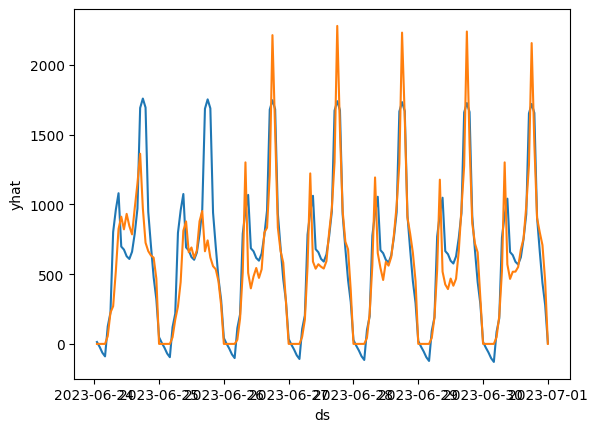

In [183]:
sns.lineplot(x=prediction['ds'], y=prediction['yhat'])
sns.lineplot(x=df_achasan5_test['ds'], y=df_achasan5_test['y'])


<Axes: xlabel='ds'>

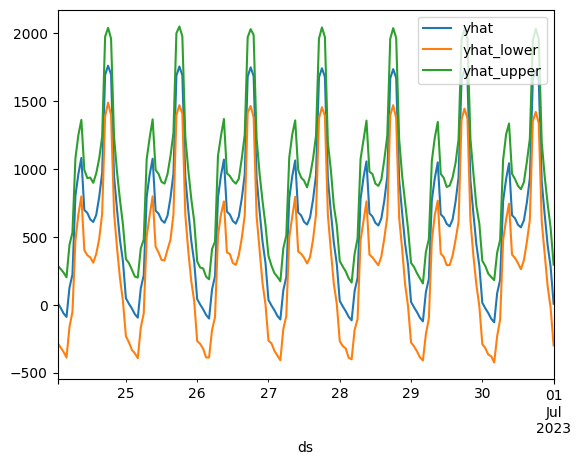

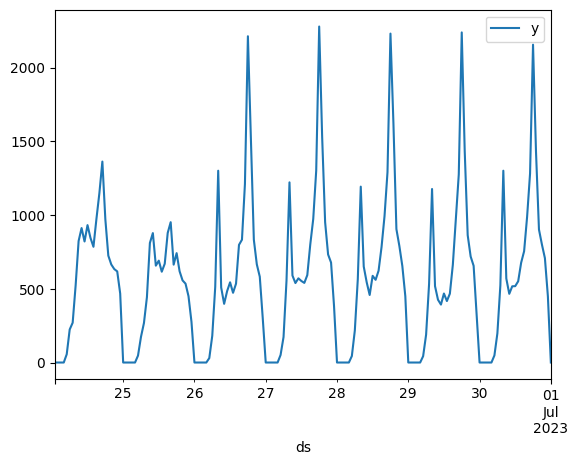

In [182]:
prediction = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prediction.plot(x='ds')
df_achasan5_test.plot(x='ds')


### Cross Validation


In [50]:
df_cv = cross_validation(m, initial= '400 days', period='50 days', horizon = '2 days')


  0%|          | 0/4 [00:00<?, ?it/s]

17:15:28 - cmdstanpy - INFO - Chain [1] start processing
17:15:29 - cmdstanpy - INFO - Chain [1] done processing
17:15:31 - cmdstanpy - INFO - Chain [1] start processing
17:15:32 - cmdstanpy - INFO - Chain [1] done processing
17:15:33 - cmdstanpy - INFO - Chain [1] start processing
17:15:35 - cmdstanpy - INFO - Chain [1] done processing
17:15:37 - cmdstanpy - INFO - Chain [1] start processing
17:15:38 - cmdstanpy - INFO - Chain [1] done processing


In [51]:
df_cv[['ds','yhat','y']].head(20)


,ds,yhat,y
0,2022-04-03 01:00:00,-34.742873,0.0
1,2022-04-03 02:00:00,-116.047219,0.0
2,2022-04-03 03:00:00,-173.191977,0.0
3,2022-04-03 04:00:00,-154.656883,0.0
4,2022-04-03 05:00:00,-41.825803,42.0
5,2022-04-03 06:00:00,130.045336,89.0
6,2022-04-03 07:00:00,299.210336,129.0
7,2022-04-03 08:00:00,421.178356,344.0
8,2022-04-03 09:00:00,487.040439,883.0
9,2022-04-03 10:00:00,507.428839,1093.0


#### Performance metrics

In [140]:
df_p = performance_metrics(df_cv)
df_p.head(10)
np.mean(df_p['mae'])


127.2219131072392

In [158]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003],
    'seasonality_prior_scale': [10.0, 12.0, 20.0],
    'holidays_prior_scale' : [9.0, 10.0, 15.0],
    'seasonality_mode' : ['multiplicative']

}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  # Fit model with given params
    m.add_country_holidays(country_name='KR')
    m.add_regressor('is_morning_peak')
    m.add_regressor('is_afternoon_peak')
    m.add_regressor('is_closed')
    m.fit(df_achasan5_train)
    df_cv = cross_validation(m, initial='400 days', period='100 days', horizon = '2 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)


12:14:17 - cmdstanpy - INFO - Chain [1] start processing
12:14:17 - cmdstanpy - INFO - Chain [1] done processing
12:14:18 - cmdstanpy - INFO - Chain [1] start processing
12:14:18 - cmdstanpy - INFO - Chain [1] done processing
12:14:19 - cmdstanpy - INFO - Chain [1] start processing
12:14:19 - cmdstanpy - INFO - Chain [1] done processing
12:14:20 - cmdstanpy - INFO - Chain [1] start processing
12:14:21 - cmdstanpy - INFO - Chain [1] done processing
12:14:21 - cmdstanpy - INFO - Chain [1] start processing
12:14:22 - cmdstanpy - INFO - Chain [1] done processing
12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing
12:14:24 - cmdstanpy - INFO - Chain [1] start processing
12:14:24 - cmdstanpy - INFO - Chain [1] done processing
12:14:25 - cmdstanpy - INFO - Chain [1] start processing
12:14:25 - cmdstanpy - INFO - Chain [1] done processing
12:14:26 - cmdstanpy - INFO - Chain [1] start processing
12:14:26 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                     0.001                     10.0                   9.0   
1                     0.001                     10.0                  10.0   
2                     0.001                     10.0                  15.0   
3                     0.001                     12.0                   9.0   
4                     0.001                     12.0                  10.0   
5                     0.001                     12.0                  15.0   
6                     0.001                     20.0                   9.0   
7                     0.001                     20.0                  10.0   
8                     0.001                     20.0                  15.0   
9                     0.002                     10.0                   9.0   
10                    0.002                     10.0                  10.0   
11                    0.002                     10.0            

12:15:31 - cmdstanpy - INFO - Chain [1] done processing


### Hyperparameter Tuning

In [162]:
tuning_results.iloc[rmses.index(min(rmses))]


changepoint_prior_scale             0.002
seasonality_prior_scale              10.0
holidays_prior_scale                 10.0
seasonality_mode           multiplicative
rmse                           157.325373
Name: 10, dtype: object

In [118]:
best_params = all_params[np.argmin(rmses)]
print(best_params)


{'changepoint_prior_scale': 0.002, 'seasonality_prior_scale': 12.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


### Fit

In [153]:
#trying with the params of the grid search
m_tuned = Prophet(changepoint_prior_scale=0.002, seasonality_prior_scale=3.0,
                  holidays_prior_scale=0.02, seasonality_mode='multiplicative')
m_tuned.add_country_holidays(country_name='KR')
m_tuned.fit(df_156_short)


12:59:57 - cmdstanpy - INFO - Chain [1] start processing
12:59:57 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
future = m.make_future_dataframe(periods=200, freq='h', include_history=False)
future


,ds
0,2023-03-01 08:00:00
1,2023-03-01 09:00:00
2,2023-03-01 10:00:00
3,2023-03-01 11:00:00
4,2023-03-01 12:00:00
...,...
195,2023-03-09 11:00:00
196,2023-03-09 12:00:00
197,2023-03-09 13:00:00
198,2023-03-09 14:00:00


In [155]:
forecast_tuned = m_tuned.predict(future)
forecast_tuned[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)


,ds,yhat,yhat_lower,yhat_upper
190,2023-03-09 06:00:00,570.396311,249.964368,881.843290
191,2023-03-09 07:00:00,735.396446,428.342383,1045.648809
192,2023-03-09 08:00:00,791.958568,478.554251,1096.795750
193,2023-03-09 09:00:00,783.226276,445.650041,1082.860534
194,2023-03-09 10:00:00,762.570177,456.928645,1062.976646
195,2023-03-09 11:00:00,747.596659,406.681683,1065.992870
196,2023-03-09 12:00:00,733.108552,433.157518,1049.979694
197,2023-03-09 13:00:00,736.399076,420.372531,1050.649584
198,2023-03-09 14:00:00,809.329319,496.621291,1113.647231
199,2023-03-09 15:00:00,988.522997,679.371827,1310.140042


In [135]:
plot_plotly(model, forecast)


In [136]:
plot_components_plotly(model, forecast)
